In [1]:
# Allow access to parent directory
import sys
import os
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(1, parent_path)

from helper import download_dataset

from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-11-07 21:37:51.663384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 21:37:52.762195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-11-07 21:37:54.596716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:37:54.793444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:37:54.793495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Set Global Variables
DATASET_FP = "../WatClaimCheck_dataset" # CHANGE TO MATCH LOCAL
checkpoint = 'distilroberta-base'
max_seq_len = 128

In [3]:
# Retrieve dataset
train_df, valid_df, test_df = download_dataset(DATASET_FP)
print(train_df.count())
print(valid_df.count())
print(test_df.count())

Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
claimant            19751
claim               26976
claim_date          19190
review_date         26976
premise_articles    26976
reviewer_name       26976
reviewer_site       26976
review_url          26976
rating              26976
original_rating     26976
review_article      26976
dtype: int64
claimant            2476
claim               3372
claim_date          2407
review_date         3372
premise_articles    3372
reviewer_name       3372
reviewer_site       3372
review_url          3372
rating              3372
original_rating     3372
review_article      3372
dtype: int64
claimant            2450
claim               3373
claim_date          2384
review_date         3373
premise_articles    3373
reviewer_name       3373
reviewer_site       3373
review_url          3373
rating              3373
origi

In [4]:
roberta_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
roberta_model = TFRobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

2023-11-07 21:38:06.342181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:38:06.342325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:38:06.342375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:38:07.601901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-07 21:38:07.601989: I tensorflow/compile

In [5]:
num_train_examples = 26976 # 26976
num_valid_examples = 3372 # 3372
encoder = OneHotEncoder(sparse_output=False)

train_inputs = roberta_tokenizer(
    train_df['claim'][:num_train_examples].to_list(),
    max_length=max_seq_len,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

train_labels = encoder.fit_transform(np.array(train_df['rating']).reshape(-1, 1))

valid_inputs = roberta_tokenizer(
    valid_df['claim'][:num_valid_examples].to_list(),
    max_length=max_seq_len,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)

valid_labels = encoder.fit_transform(np.array(valid_df['rating']).reshape(-1, 1))

In [6]:
hidden_size = 100
learning_rate = 1e-5

input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int64, name='input_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int64, name='attention_mask_layer')

roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

roberta_model.trainable = True
roberta_outputs = roberta_model(roberta_inputs)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=roberta_outputs)

model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(average='macro')
    ]
)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 128)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   8212070   ['attention_mask_layer[0][0]',
 assification (TFRobertaFor  (loss=None, logits=(None,    7          'input_ids_layer[0][0]'] 

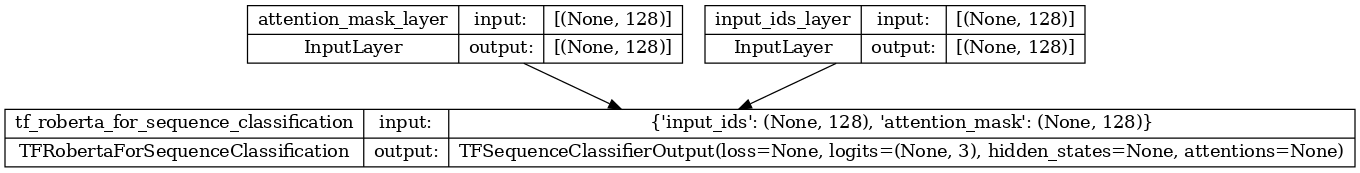

In [8]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [9]:
batch_size = 12
epochs = 10
checkpoint_path = "training/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model_history = model.fit(
    [train_inputs.input_ids, train_inputs.attention_mask], train_labels,
    validation_data=([valid_inputs.input_ids, valid_inputs.attention_mask], valid_labels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[cp_callback]
)

Epoch 1/10


2023-11-07 21:38:35.115943: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b6feb24000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 21:38:35.116043: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2023-11-07 21:38:35.151434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-07 21:38:35.211208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2023-11-07 21:38:35.542797: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2248/2248 [==============================] - ETA: 0s - loss: 1.2671 - categorical_accuracy: 0.3034 - precision: 0.4394 - recall: 0.3041 - f1_score: 0.3018
Epoch 1: saving model to training/cp.ckpt
2248/2248 [==============================] - 424s 180ms/step - loss: 1.2671 - categorical_accuracy: 0.3034 - precision: 0.4394 - recall: 0.3041 - f1_score: 0.3018 - val_loss: 0.8954 - val_categorical_accuracy: 0.1026 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0674
Epoch 2/10
2248/2248 [==============================] - ETA: 0s - loss: 0.9388 - categorical_accuracy: 0.4701 - precision: 0.4295 - recall: 0.7593 - f1_score: 0.3892
Epoch 2: saving model to training/cp.ckpt
2248/2248 [==============================] - 398s 177ms/step - loss: 0.9388 - categorical_accuracy: 0.4701 - precision: 0.4295 - recall: 0.7593 - f1_score: 0.3892 - val_loss: 0.8749 - val_categorical_accuracy: 0.5940 - val_precision: 0.4503 - val_recall: 0.8891 - val_f1_score: 0.4184
Epoch 3/10
2248/2

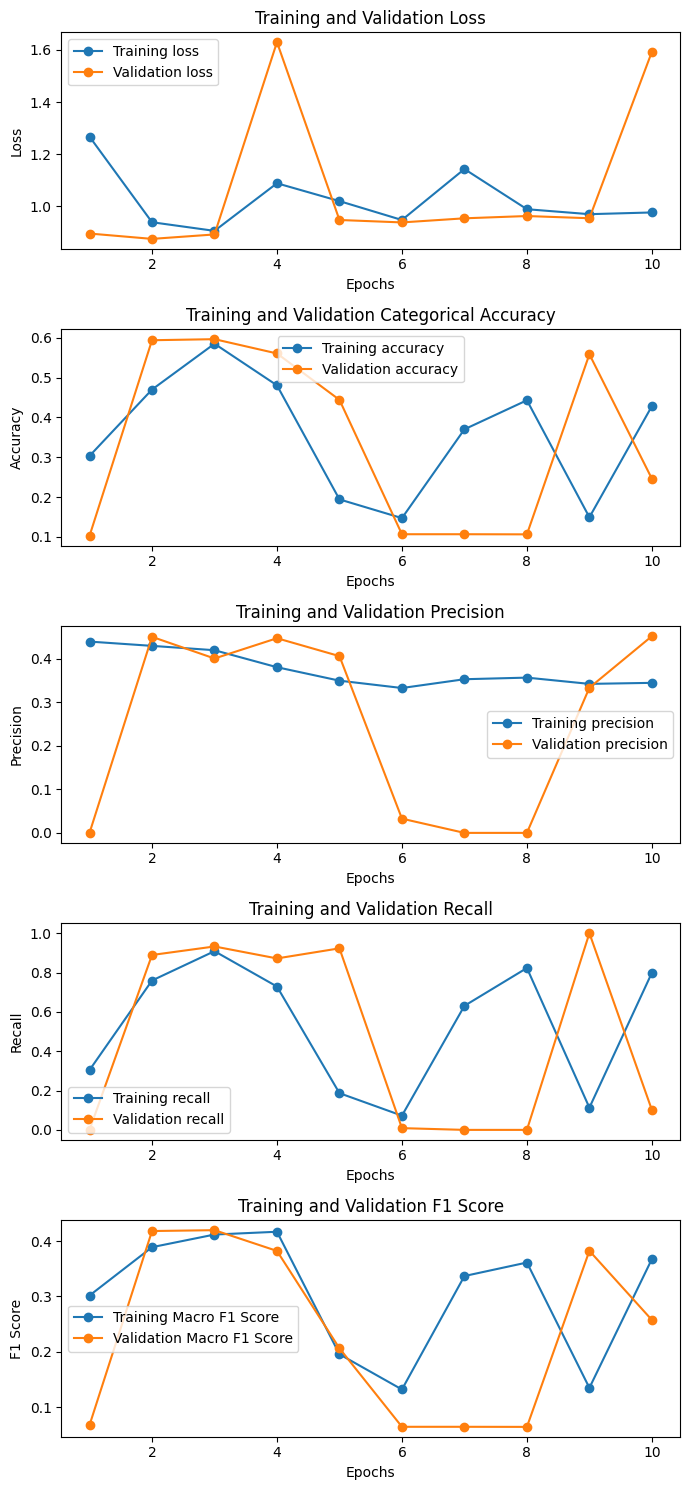

In [11]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(7, 15))
epochs = range(1, len(model_history.history['loss']) + 1)

axes[0].plot(epochs, model_history.history["loss"], 'o-', label='Training loss')
axes[0].plot(epochs, model_history.history["val_loss"], 'o-', label='Validation loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, model_history.history['categorical_accuracy'], 'o-', label='Training accuracy')
axes[1].plot(epochs, model_history.history['val_categorical_accuracy'], 'o-', label='Validation accuracy')
axes[1].set_title('Training and Validation Categorical Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

axes[2].plot(epochs, model_history.history["precision"], 'o-', label='Training precision')
axes[2].plot(epochs, model_history.history["val_precision"], 'o-', label='Validation precision')
axes[2].set_title('Training and Validation Precision')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Precision')
axes[2].legend()

axes[3].plot(epochs, model_history.history["recall"], 'o-', label='Training recall')
axes[3].plot(epochs, model_history.history["val_recall"], 'o-', label='Validation recall')
axes[3].set_title('Training and Validation Recall')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Recall')
axes[3].legend()

axes[4].plot(epochs, model_history.history["f1_score"], 'o-', label='Training Macro F1 Score')
axes[4].plot(epochs, model_history.history["val_f1_score"], 'o-', label='Validation Macro F1 Score')
axes[4].set_title('Training and Validation F1 Score')
axes[4].set_xlabel('Epochs')
axes[4].set_ylabel('F1 Score')
axes[4].legend()

plt.tight_layout()
plt.show()